In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize


Classification problem with KNN on old dataset to compare with other models

# Import and prepair dataset

In [33]:
# Importing clean, ready to go dataset from previous exercise 2
df = pd.read_csv("log_reg_df_clean.csv")
metrics_df = pd.read_csv("metrics_df.csv")

# X = everything else in the DataFrame minus the target variable
# y = only the target variable
X = df.drop('booking_status', axis=1)
y = df['booking_status']

# split the data into train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Default Model

## K value

Based on iterations, best k-value is this:
7


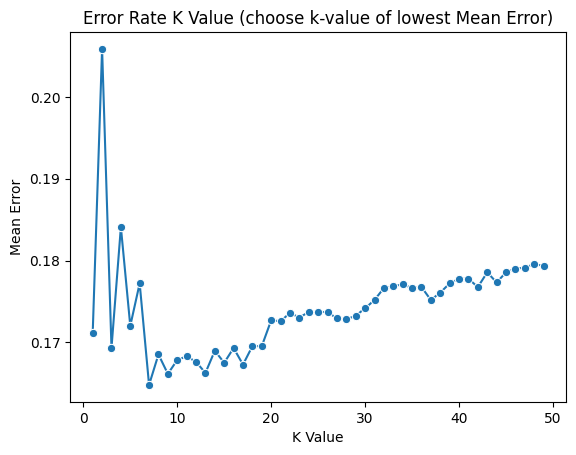

In [34]:
max_iterations = 50
# list to save the error values in the loop
error = []
# Calculating error for K values between 1 and 40
for i in range(1, max_iterations):

     # try with current k-value, train the model and make a test prediction
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=i))
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)

    # save the error value for this k-value
    error.append(np.mean(pred_i != y_test))
    
# plot all the k-values and their error values
sns.lineplot(x=range(1, max_iterations), y=error, marker='o')
plt.title('Error Rate K Value (choose k-value of lowest Mean Error)')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# choose best k-value based on metrics
# we have to add +1 to k-value, since argmin() returns an index
# which starts from 0, but k-values start from 1
print("Based on iterations, best k-value is this:")
k_value = np.argmin(error) + 1
print(k_value)



## Training

In [35]:
# build the model with the optimal values
model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k_value))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])

## Metrics

In [36]:
# get predictions for error metrics
predictions = model.predict(X_test)
 # print the classification report based on true values and predictions
report = classification_report(y_test, predictions, output_dict=True)
# get overall accuracy of the model
acc = round(accuracy_score(y_test, predictions), 2)
# get roc acu score of the model
roc_auc = roc_auc_score(y_test.values, model.predict_proba(X_test)[:, 1 ])

metrics_df["KNN default"] = [acc,
                           round(report['macro avg']['precision'], 2),
                           round(report['macro avg']['recall'], 2),
                           round(report['macro avg']['f1-score'], 2),
                           round(report['weighted avg']['precision'], 2),
                           round(report['weighted avg']['recall'], 2),
                           round(report['weighted avg']['f1-score'], 2),
                           roc_auc]

In [37]:
metrics_df

,Metric,Basic Model,StandardScaler + Regularization + LogisticRegression,Basic SVC,"SVC, linear kernel","SVC, rbf hightuned","SVC, poly kernel","SVC, sigmoid kernel",LinearSVC,NuSVC,"NuSVC, poly kernel",RFC,RFC default,KNN default
0,Total accuracy,0.78,0.81,0.82,0.78,0.85,0.83,0.69,0.880000,0.850000,0.83,0.870000,0.880000,0.840000
1,Macro precision,0.77,0.80,0.81,0.76,0.84,0.82,0.65,0.870000,0.840000,0.82,0.860000,0.870000,0.820000
2,Macro recall,0.75,0.78,0.78,0.74,0.81,0.80,0.65,0.860000,0.820000,0.79,0.850000,0.860000,0.810000
3,Macro F1,0.75,0.78,0.79,0.75,0.82,0.81,0.65,0.860000,0.820000,0.80,0.860000,0.870000,0.820000
4,Weighted precision,0.78,0.81,0.82,0.78,0.84,0.83,0.69,0.880000,0.840000,0.83,0.870000,0.880000,0.830000
5,Weighted recall,0.78,0.81,0.82,0.78,0.85,0.83,0.69,0.880000,0.850000,0.83,0.870000,0.880000,0.840000
6,Weighted F1,0.78,0.81,0.82,0.78,0.84,0.83,0.69,0.880000,0.840000,0.83,0.870000,0.880000,0.830000
7,ROC AUC,0.76,0.61,0.88,0.84,0.88,0.87,0.71,0.933905,0.877527,0.87,0.879814,0.882385,0.895944


<AxesSubplot: >

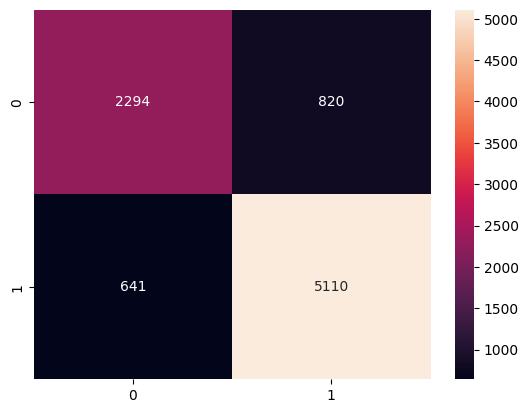

In [38]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

# Optimized Mode

## Tuning

In [39]:
# We need to add prefix kneighborsclassifier__ in order to make it work with scikit pipeline.
# Without it, parameters would be passed not to KNeighborsClassifier(), but to piepline in general, which will raise error
param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(1, 26)),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    }

In [40]:
# True - perform optimization and save best parameters. WARNING: takes some time (10min)
# False - load best parameters from file 
OPTIMIZATION = False

In [41]:
# WARNING! Optimization takes some time (10min+)
if OPTIMIZATION:
    pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    with open('best_params_clf2.pkl', 'wb') as f:
        pickle.dump(best_params, f)
else:
    # Load parameters without optimization
    with open('best_params_clf2.pkl', 'rb') as f:
        best_params = pickle.load(f)

## Best parameters

In [42]:
# Strip prefix before passing them to estimator
best_params = {k.replace('kneighborsclassifier__', ''): v for k, v in best_params.items() if k.startswith('kneighborsclassifier__')}
# Print best parameters and score
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {}
Best Cross-Validation Score: 0.8554508097655307


## Training

In [43]:
best_model = make_pipeline(StandardScaler(), KNeighborsClassifier(**best_params))
best_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

## Metrics

In [44]:
# get predictions for error metrics
predictions = model.predict(X_test)
 # print the classification report based on true values and predictions
report = classification_report(y_test, predictions, output_dict=True)
# get overall accuracy of the model
acc = round(accuracy_score(y_test, predictions), 2)
# get roc acu score of the model
roc_auc = roc_auc_score(y_test.values, model.predict_proba(X_test)[:, 1 ])

metrics_df["KNN"] = [acc,
                           round(report['macro avg']['precision'], 2),
                           round(report['macro avg']['recall'], 2),
                           round(report['macro avg']['f1-score'], 2),
                           round(report['weighted avg']['precision'], 2),
                           round(report['weighted avg']['recall'], 2),
                           round(report['weighted avg']['f1-score'], 2),
                           roc_auc]
metrics_df

,Metric,Basic Model,StandardScaler + Regularization + LogisticRegression,Basic SVC,"SVC, linear kernel","SVC, rbf hightuned","SVC, poly kernel","SVC, sigmoid kernel",LinearSVC,NuSVC,"NuSVC, poly kernel",RFC,RFC default,KNN default,KNN
0,Total accuracy,0.78,0.81,0.82,0.78,0.85,0.83,0.69,0.880000,0.850000,0.83,0.870000,0.880000,0.840000,0.840000
1,Macro precision,0.77,0.80,0.81,0.76,0.84,0.82,0.65,0.870000,0.840000,0.82,0.860000,0.870000,0.820000,0.820000
2,Macro recall,0.75,0.78,0.78,0.74,0.81,0.80,0.65,0.860000,0.820000,0.79,0.850000,0.860000,0.810000,0.810000
3,Macro F1,0.75,0.78,0.79,0.75,0.82,0.81,0.65,0.860000,0.820000,0.80,0.860000,0.870000,0.820000,0.820000
4,Weighted precision,0.78,0.81,0.82,0.78,0.84,0.83,0.69,0.880000,0.840000,0.83,0.870000,0.880000,0.830000,0.830000
5,Weighted recall,0.78,0.81,0.82,0.78,0.85,0.83,0.69,0.880000,0.850000,0.83,0.870000,0.880000,0.840000,0.840000
6,Weighted F1,0.78,0.81,0.82,0.78,0.84,0.83,0.69,0.880000,0.840000,0.83,0.870000,0.880000,0.830000,0.830000
7,ROC AUC,0.76,0.61,0.88,0.84,0.88,0.87,0.71,0.933905,0.877527,0.87,0.879814,0.882385,0.895944,0.895944


<AxesSubplot: >

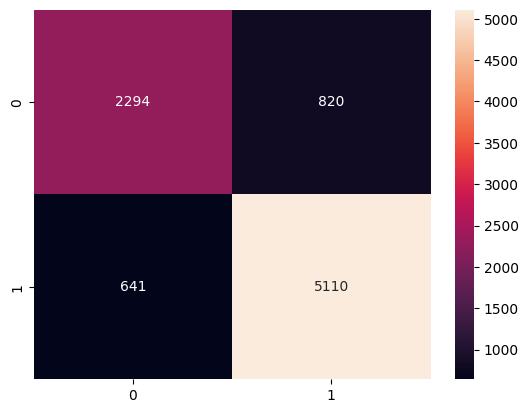

In [45]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

In [46]:
# save metrics 
metrics_df.to_csv('metrics_df.csv', index=False)

# Conclusion
Surprisingly, KNN worked pretty well even with this dataset. Almost every model showed quite good results, so I guess there is not that much overlaps, noise or anything like that and classes are very well distinguishable. KNN showed 0.84 accuracy and 0.90 ROC AUC, however recall was not so great which can also be seen on confusion matrix, as model is not very accurate with minority class.

In terms of hyper parameter tuning, there is almost nothing we can do. Changing distance metric or algorithm doesn't really work out in this case. There is a possibility to go deeper with Minkowski metric - there is a power parameter. Another one is that you can control speed/perfomance ratio with leaf size parameter for tree based algorithm (ball_tree or kd_tree). But I think these are such details that won't provide you anything usefull unless you are quite sure that KNN is the best estimator for concrete situation and you want to squeeze as much as possible.